<img src="../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Comparing Strings with Quantum Superpositon*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q Experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).


***
### Contributors
Rudy Raymond

## Motivation

If we can use quantum states to represent genetic codes, we may be able to compare them, and/or find similar genetic codes quickly. 

For example, according to [this site](http://www.bioinformatics.org/sms2/genetic_code.html) the starts of the genetic codes for the Yeast Mitochondrial, Protozoan Mitochondrial, and Bacterial Code are respectively as follow. 

In [1]:
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"

Notice that each of the codes is represented by a bitstring of length 64. By comparing characters at the same position in the strings, we can see that Protozoan's is closer to Bacterial's than Yeast's. 

Exploiting quantum superposition, we can create quantum states by using only 7 qubits such that each of the quantum states corresponds to the genetic code of Yeast, Protozoan, and Bacterial. We then compare the closeness of their genetic codes by comparing their quantum states, which is made possible by the reversibility of quantum circuit.

The reversibility of quantum circuit to test the similarity of quantum states works as follow. Assume that we can create a quantum superposition starting from all-zero states by a quantum circuit. Then by inverting the same quantum circuit and we give it the same quantum superposition as input, we will get exactly all-zero bits as the output. Now, when we give a similar quantum superposition as input to the inverted circuit, we can still get all-zero bits as the output with probability proportional to the similarity of the quantum states: the more similar, the more we observe all-zero bits. 

Thus, to decide which code (*Yeast's* *or* *Bacterial's*) is the most similar to the Protozoan, we can do the following:

1. We first prepare the quantum state that encodes the Protozoan's
2. We then use the quantum state as inputs to the inverted circuits that each prepare the quantum state of Yeast's and Bacterial's. Run and measure the circuits
3. Output the name of the inverted circuit whose measurements result in more frequent measurements of all-zero bits. 


## Quantum Superposition for Bitstring

A qubit can be in a superposition of two basis states: "0" and "1" at the same time. Going further, two qubits can be in a superposition of four basis states: "00", "01", "10", and "11". In general, $n$ qubits can be in a superposition of $2^n$ (exponential in the number of qubits!) basis states. 

Here, we show a simple example to create quantum superpositon for bitstrings and use them to compare the similarity between two bitstrings. This tutorial makes use the [quantum state initialization function](https://nbviewer.jupyter.org/github/QISKit/qiskit-tutorial/blob/master/reference/tools/quantum_gates_and_linear_algebra.ipynb#Arbitrary-initialization) and **circuit inversion**. It also illustrates the power of loading data into quantum states. 

## Comparing bitstrings of length 64 with 7 qubits

Let say we have three genetic codes as above.

```
YEAST     = "----------------------------------MM----------------------------"
PROTOZOAN = "--MM---------------M------------MMMM---------------M------------"
BACTERIAL = "---M---------------M------------MMMM---------------M------------"
```

Let use 7 qubits to encode the above codes: the first 6 qubits for indexing the location in the code (because we have 64 positions that we number from 0 to 63), and the last qubit for the content of the code (we use "0" for "-" and "1" for "M"). Thus, numbering the position of the code from left to right, we can create quantum states for each of the code as below: 

\begin{eqnarray}
|{\mbox{YEAST}} \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle  + |000010\rangle |0\rangle + |000011\rangle |0\rangle + \ldots \right) \\
|{\mbox{PROTOZOAN}} \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle + |000010\rangle |1\rangle + |000011\rangle |1\rangle + \ldots \right) \\
|{\mbox{BACTERIAL}} \rangle &=& \frac{1}{8} \left( |000000\rangle |0\rangle +  |000001\rangle |0\rangle + |000010\rangle |0\rangle + |000011\rangle |1\rangle + \ldots \right)
\end{eqnarray}

The first four codes of Yeast's are all "-", and therefore at the above all of the second registers of the corresponding state are "0". And so on. 

### Creating quantum superposition for genetic codes

Below is the python function to create a quantum superposition for a given genetic code as above. 

In [2]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import CompositeGate

def encode_bitstring(bitstring, qr, cr, inverse=False):
    """
    create a circuit for constructing the quantum superposition of the bitstring
    """
    n = math.ceil(math.log2(len(bitstring))) + 1                 #number of qubits
    assert n > 2, "the length of bitstring must be at least 2"
    
    qc = QuantumCircuit(qr, cr)
    
    #the probability amplitude of the desired state
    desired_vector = np.array([ 0.0 for i in range(2**n) ])     #initialize to zero
    amplitude = np.sqrt(1.0/2**(n-1))
    
    for i, b in enumerate(bitstring):
        pos = i * 2
        if b == "1" or b == "M":
            pos += 1
        desired_vector[pos] = amplitude
    if not inverse:
        qc.initialize(desired_vector, [ qr[i] for i in range(n) ] )
        qc.barrier(qr)
    else:
        qc.initialize(desired_vector, [ qr[i] for i in range(n) ] ).inverse()  #invert the circuit
        for i in range(n):
            qc.measure(qr[i], cr[i])
    print()
    return qc

We can now create quantum circuits to create the quantum states for the Yeast's, Protozoan's, and Bacterial's.

In [3]:
n = math.ceil(math.log2(len(YEAST))) + 1                 #number of qubits
qr = QuantumRegister(n)
cr = ClassicalRegister(n)

qc_yeast     = encode_bitstring(YEAST, qr, cr)
qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr)
qc_bacterial = encode_bitstring(BACTERIAL, qr, cr)

circs = {"YEAST": qc_yeast, "PROTOZOAN": qc_protozoan, "BACTERIAL": qc_bacterial}

### Inversing quantum circuit

We can easily inverse a quantum circuit by `inverse()` function. These inverse circuits are desirable to compute the closeness of the quantum states. The intuition 

In [4]:
inverse_qc_yeast     = encode_bitstring(YEAST,     qr, cr, inverse=True)
inverse_qc_protozoan = encode_bitstring(PROTOZOAN, qr, cr, inverse=True)
inverse_qc_bacterial = encode_bitstring(BACTERIAL, qr, cr, inverse=True)

inverse_circs = {"YEAST": inverse_qc_yeast, "PROTOZOAN": inverse_qc_protozoan, "BACTERIAL": inverse_qc_bacterial}

### Comparing bitsrings

We can now compare how close the starts of the genetic codes of Protozoan to Yeast's and Bacterial's by performing the test.

In [5]:
import sys
#to run quantum circuits
from qiskit import execute, register, available_backends

print("Available backends:", available_backends())


key = "PROTOZOAN"       #the name of the code used as key to find similar ones

# use local simulator
backend = "local_qasm_simulator"
shots = 1000

combined_circs = {}
count = {}

most_similar, most_similar_score = "", -1.0

for other_key in inverse_circs:
    if other_key == key:
        continue
        
    combined_circs[other_key] = circs[key] + inverse_circs[other_key]   #combined circuits to look for similar codes
    job = execute(combined_circs[other_key], backend=backend,shots=shots)
    st = job.result().get_counts(combined_circs[other_key])
    if "0"*n in st:
        sim_score = st["0"*n]/shots
    else:
        sim_score = 0.0
    
    print("Similarity score of",key,"and",other_key,"is",sim_score)
    if most_similar_score < sim_score:
        most_similar, most_similar_score = other_key, sim_score

print("[ANSWER]", key,"is most similar to", most_similar)

Available backends: ['local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']
Similarity score of PROTOZOAN and YEAST is 0.828
Similarity score of PROTOZOAN and BACTERIAL is 0.968
[ANSWER] PROTOZOAN is most similar to BACTERIAL


### Drawing the circuits

We see the circuits that generate the quantum states of the codes and their inversions.

Circuit of PROTOZOAN


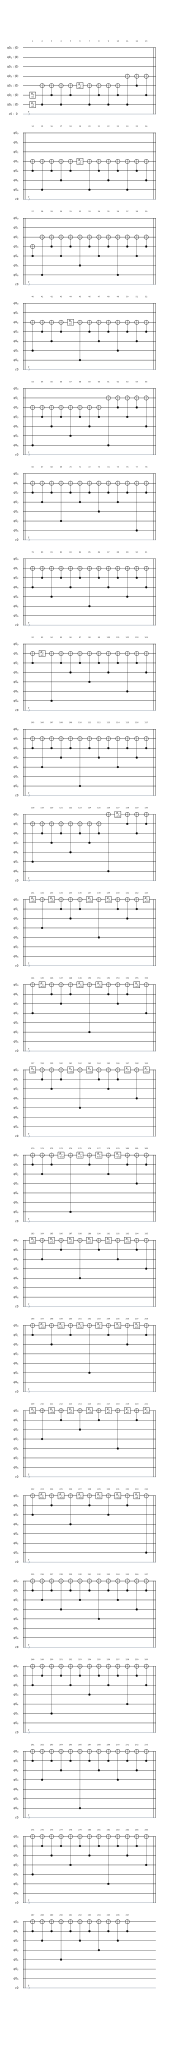

In [6]:
#draw the circuit
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer, qx_color_scheme

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

my_style = {'compress': True, "usepiformat": True, "showindex": True, "cregbundle":True, "scale":1.0, "fold":13}
print("Circuit of PROTOZOAN")
drawer(circs["PROTOZOAN"], style=my_style)

Circuit of YEAST


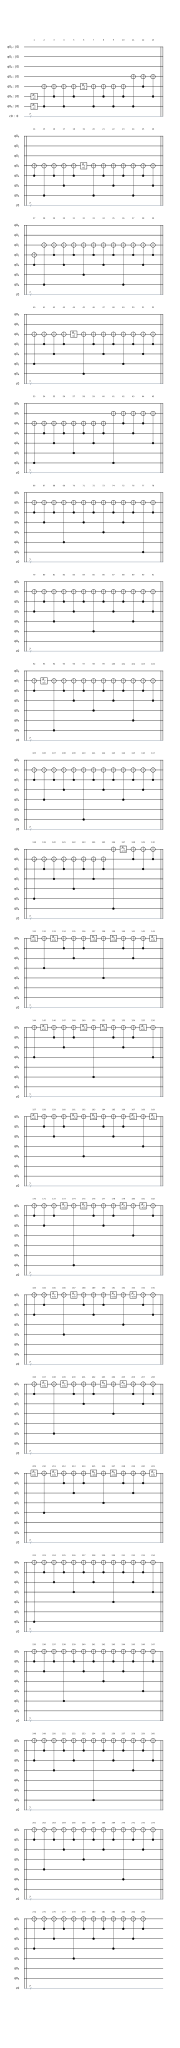

In [7]:
print("Circuit of YEAST")
drawer(circs["YEAST"], style=my_style)

Circuit of BACTERIAL


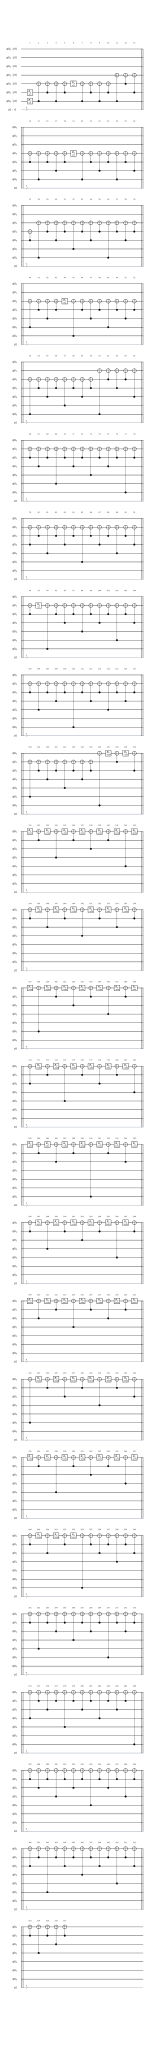

In [8]:
print("Circuit of BACTERIAL")
drawer(circs["BACTERIAL"], style=my_style)

Circuit of PROTOZOAN compared with YEAST


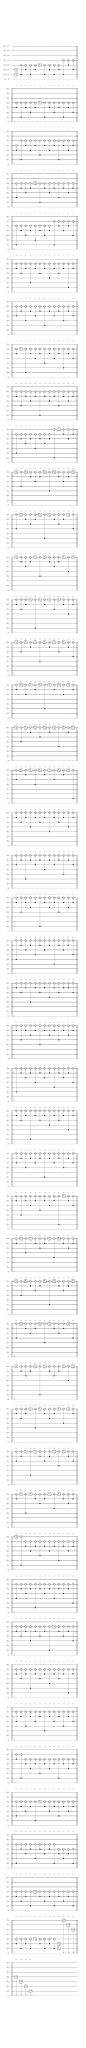

In [9]:
print("Circuit of PROTOZOAN compared with YEAST")
drawer(circs["PROTOZOAN"] + inverse_circs["YEAST"], style=my_style)

Circuits of PROTOZOAN compared with BACTERIAL


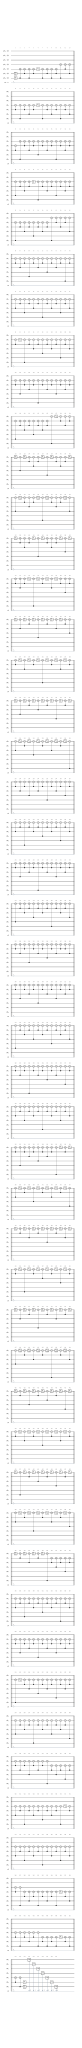

In [10]:
print("Circuits of PROTOZOAN compared with BACTERIAL")
drawer(circs["PROTOZOAN"] + inverse_circs["BACTERIAL"], style=my_style)

In [11]:
!pip show qiskit

Name: qiskit
Version: 0.5.7
Summary: Software for developing quantum computing programs
Home-page: https://github.com/QISKit/qiskit-terra
Author: QISKit Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /Users/rraymondhp/miniconda3/envs/QISKitenv/lib/python3.6/site-packages
Requires: ply, numpy, IBMQuantumExperience, scipy, networkx, matplotlib, sympy, pillow
Required-by: qiskit-acqua, qiskit-acqua-chemistry
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
